# Calcul de la constante de Lifschitz mais sans training
On a implementé le module de la class model qui pour un modele donne calcul sa constante de Lipschitz.
On compare le resultats avec deux entrées proches à une perturbation près, pour voir si on retombe sur nos pieds.

In [1]:
# importation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# local
from FBResNet.pretreat import LoadDataSet, CreateDataSet
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.model import MyModel

In [2]:
a   = 1
p   = 1
nx  = 2000
m   = 20
sim = Physics(nx,m,a,p)

In [3]:
folder  = './Datasets'
nsample = 50
train_set, val_set = CreateDataSet(sim,folder, noise=0.0, nsample=50, save='yes')

In [4]:
# Gaussian
t   = np.linspace(0,1,nx)
x   = np.exp(-(t-0.5)**2/0.01)
xc  = sim.BasisChange(x)
xi  = np.exp(-(t-0.6)**2/0.1)
xic = sim.BasisChange(x)
y   = sim.ComputeAdjoint(sim.Compute(x))
y.shape

(20,)

In [5]:
nLayers = 100

### Descente de gradient

In [6]:
gamma = 0.913
xk = y.copy()
tDD, tTT, Peig, Pelt = sim.Operators()
y2  = tTT.dot(sim.BasisChange(x))
for _ in range(nLayers):
    xk = xk-gamma*(tTT.dot(xk)-y2)

In [7]:
tTT.dot(xc)-y

array([-1.15564927e-04,  3.04008622e-05, -1.47471991e-05,  1.08688705e-05,
       -9.14016473e-06,  7.40029862e-06, -6.07031417e-06,  5.28525676e-06,
       -4.71814650e-06,  4.21385101e-06, -3.79799667e-06,  3.46986292e-06,
       -3.19565155e-06,  2.95837447e-06, -2.75362336e-06,  2.57604915e-06,
       -2.42001340e-06,  2.28167559e-06, -2.15829216e-06,  2.04758131e-06])

In [8]:
tTT.dot(xc)-y2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [9]:
eigm=(np.linspace(0,m-1,m)+1/2)*np.pi

### Modele non entrainé

In [10]:
mymodel = MyModel(sim,nL=100)

In [11]:
x0 = torch.FloatTensor(np.zeros((1,1,m))).detach()
xic= torch.FloatTensor(xic.reshape(1,1,-1)).detach()
xb = torch.FloatTensor(y.reshape(1,1,-1)).detach()

In [12]:
with torch.no_grad():
    xt = mymodel(xic,xb).detach()
xt

tensor([[[ 1.7661e-01, -1.7058e-01, -1.5493e-01,  1.3536e-01,  1.1222e-01,
          -8.8668e-02, -6.4475e-02,  4.6098e-02,  3.1406e-02, -2.0539e-02,
          -1.1778e-02,  6.8504e-03,  4.1776e-03, -2.3578e-03, -7.7148e-04,
           2.6341e-04,  4.4327e-04, -3.0795e-04,  1.5963e-04, -1.7291e-04]]])

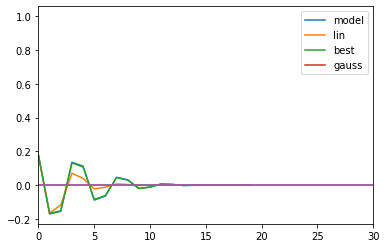

In [13]:
plt.xlim((0,30))
plt.plot(xt[0,0].numpy(),label="model")
plt.plot(xk,label="lin")
plt.plot(xc,label="best")
plt.plot(x,label="gauss")
plt.plot(np.zeros(nx))
plt.legend()

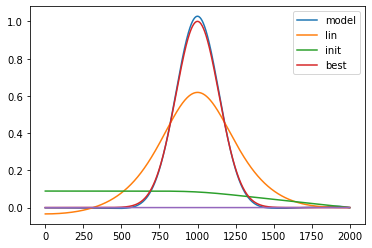

In [14]:
plt.plot(sim.BasisChangeInv(xt[0,0].numpy()),label="model")
plt.plot(sim.BasisChangeInv(xk),label="lin")
plt.plot(sim.BasisChangeInv(xb[0,0].numpy()),label="init")
plt.plot(sim.BasisChangeInv(sim.BasisChange(x)),label="best")
#plt.plot(x,label="gauss")
plt.plot(np.zeros(nx))
plt.legend()

In [15]:
mymodel.Lipschitz()

1.5796331554796404e+88

In [16]:
(2/np.pi)**2

0.40528473456935116

In [17]:
soft = nn.Softplus()

In [18]:
soft(torch.FloatTensor([0.4]))

tensor([0.9130])